# Importação das bibliotecas

In [118]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Carregamento dos Dados

- Estavam todos concatenados, apenas separados por ';'.

In [99]:
df = pd.read_csv("dataset.csv", delimiter=";")

- Apresentação de 10 linhas do dataset

In [100]:
df.head(10)

,id,issue_date,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label
0,1,2024-10-14 00:00:00.000,7101.0,True,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
1,2,2024-10-16 00:00:00.000,5839.0,True,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,True,AM,not valid
2,3,2024-10-15 16:40:24.000,974.0,False,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
3,4,2024-10-17 00:00:00.000,9099.0,True,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
4,5,2024-10-07 17:04:16.000,3434.0,False,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid
5,6,2024-10-04 00:00:00.000,6668.0,False,4.03,5540.4000,2.500000,0.0,0.0,0.0,0.0,0.00,True,AM,valid
6,7,2024-10-17 00:00:00.000,8788.0,False,4.06,1292.7600,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
7,8,2024-10-17 00:00:00.000,8788.0,False,4.06,36544.0680,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
8,9,2024-10-17 15:09:16.000,974.0,False,10.02,26.6817,2.010000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
9,10,2024-10-14 00:00:00.000,10881.0,True,4.03,1112.7255,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid


# Análise de Dados

## Informações sobre o tipo de cada feature

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16843 entries, 0 to 16842
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           16843 non-null  int64  
 1   issue_date                   16843 non-null  object 
 2   id_supplier                  16675 non-null  float64
 3   iss_retention                16843 non-null  bool   
 4   lc116                        16843 non-null  float64
 5   calculated_value             16843 non-null  float64
 6   iss_tax_rate                 16675 non-null  float64
 7   inss_tax_rate                16843 non-null  float64
 8   csll_tax_rate                16843 non-null  float64
 9   ir_tax_rate                  16843 non-null  float64
 10  cofins_tax_rate              16843 non-null  float64
 11  pis_tax_rate                 16843 non-null  float64
 12  opting_for_simples_nacional  16843 non-null  bool   
 13  state           

- 16843 linhas
- 15 features
    - 10 features numéricas
    - 5 categóricas

## Modificações no Dataset

- Conversão da coluna lc116 para String.

In [101]:
df['lc116'] = df['lc116'].astype(str)
df['lc116']

0         4.03
1         4.12
2        10.02
3         4.03
4         4.09
         ...  
16838     1.07
16839    16.01
16840     1.07
16841     4.02
16842    14.01
Name: lc116, Length: 16843, dtype: object

- Remoção da coluna ID 

In [102]:
df = df.drop('id', axis = 1)

- Separação das features numéricas e categóricas.

In [52]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

cat_cols = df.select_dtypes(include=["object", "bool"]).columns

print("Colunas Numéricas:", list(num_cols))
print("Colunas Categóricas:", list(cat_cols))

Colunas Numéricas: ['id_supplier', 'calculated_value', 'iss_tax_rate', 'inss_tax_rate', 'csll_tax_rate', 'ir_tax_rate', 'cofins_tax_rate', 'pis_tax_rate']
Colunas Categóricas: ['issue_date', 'iss_retention', 'lc116', 'opting_for_simples_nacional', 'state', 'class_label']


## Descrição geral das features numéricas

In [87]:
df.describe()

,id_supplier,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate
count,16675.000000,1.684300e+04,16675.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000
mean,5858.570675,6.026261e+03,2.789753,0.171719,0.497456,0.658386,1.527887,0.331529
std,3165.422598,2.909761e+04,2.323147,1.405455,0.538369,0.790466,1.611165,0.350895
min,6.000000,1.083000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3336.000000,5.700000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5913.000000,1.710000e+03,2.244185,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8520.500000,4.647954e+03,3.292734,0.000000,1.000000,1.500000,3.000000,0.650000
max,11241.000000,1.133142e+06,100.000000,21.446848,1.993938,2.999645,5.997115,2.930112


## Quantidade de valores ausentes

In [6]:
print(df.isnull().sum())

issue_date                       0
id_supplier                    168
iss_retention                    0
lc116                            0
calculated_value                 0
iss_tax_rate                   168
inss_tax_rate                    0
csll_tax_rate                    0
ir_tax_rate                      0
cofins_tax_rate                  0
pis_tax_rate                     0
opting_for_simples_nacional      0
state                          168
class_label                      0
dtype: int64


## Percentual de valores ausentes

In [89]:
print((df.isnull().sum() / len(df)) * 100)

issue_date                     0.000000
id_supplier                    0.997447
iss_retention                  0.000000
lc116                          0.000000
calculated_value               0.000000
iss_tax_rate                   0.997447
inss_tax_rate                  0.000000
csll_tax_rate                  0.000000
ir_tax_rate                    0.000000
cofins_tax_rate                0.000000
pis_tax_rate                   0.000000
opting_for_simples_nacional    0.000000
state                          0.997447
class_label                    0.000000
dtype: float64


- como nas colunas categóricas, os valores ausentes são cerca de 1% dos dados totais, essas linhas com dados ausentes provavelmente serão removidas.

## Valores únicos para colunas categóricas

In [90]:
print(df[cat_cols].nunique())

issue_date                     9303
iss_retention                     2
lc116                           118
opting_for_simples_nacional       2
state                             5
class_label                       2
dtype: int64


- Não será considerada as datas para análise de dados

In [96]:
cat_cols = cat_cols[1:]

- Valores únicos graficamente para cada coluna

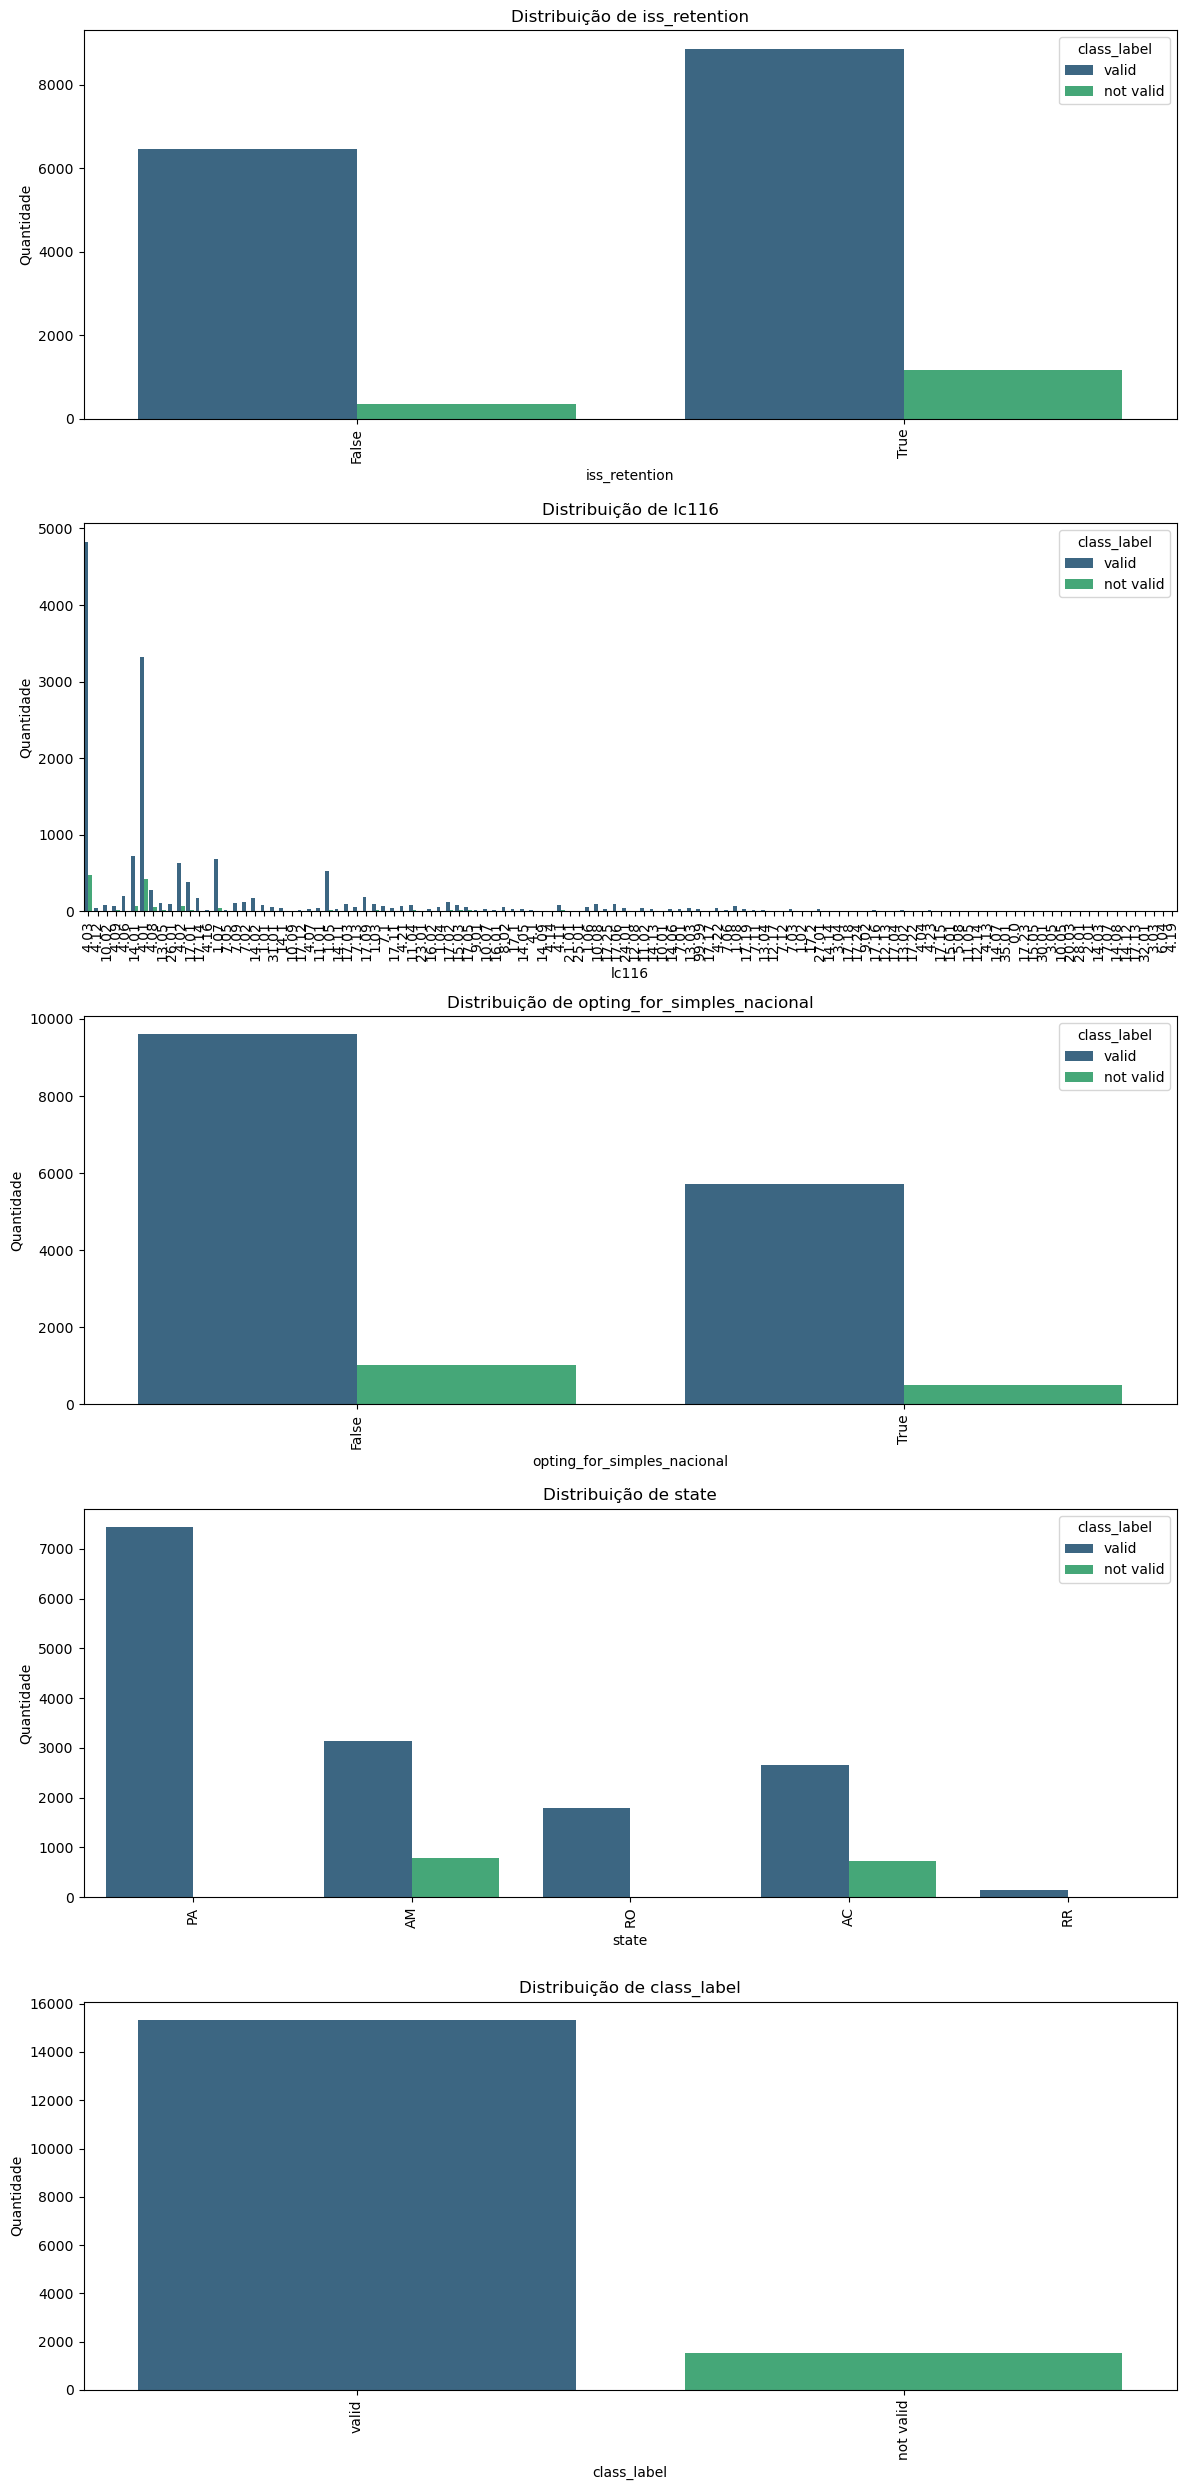

In [74]:
plt.figure(figsize=(12, 5 * len(cat_cols[1:])))

for i, col in enumerate(cat_cols[1:], 1):
    plt.subplot(len(cat_cols[1:]), 1, i)
    sns.countplot(data=df, x=col, palette="viridis", hue="class_label")
    plt.xticks(rotation=90) 
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Quantidade")

plt.tight_layout()
plt.show()

- Verificação da quantidade de itens por rótulos

In [54]:
print(df["class_label"].value_counts())

class_label
valid        15320
not valid     1523
Name: count, dtype: int64


## Histograma para as variáveis numéricas

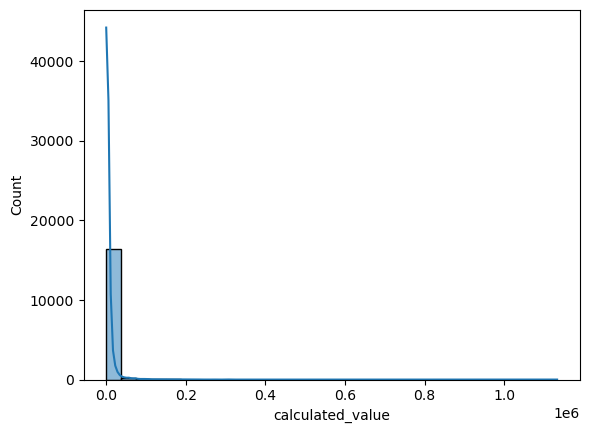

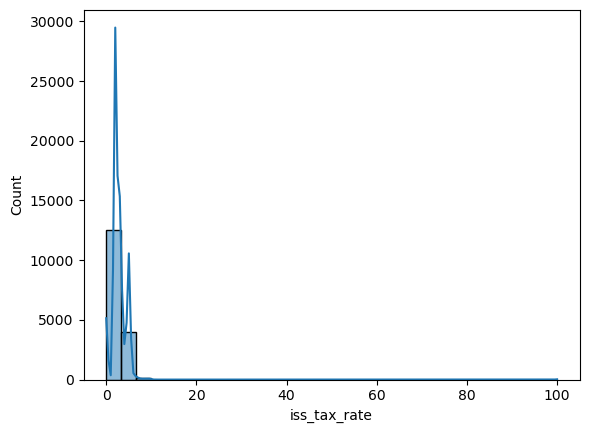

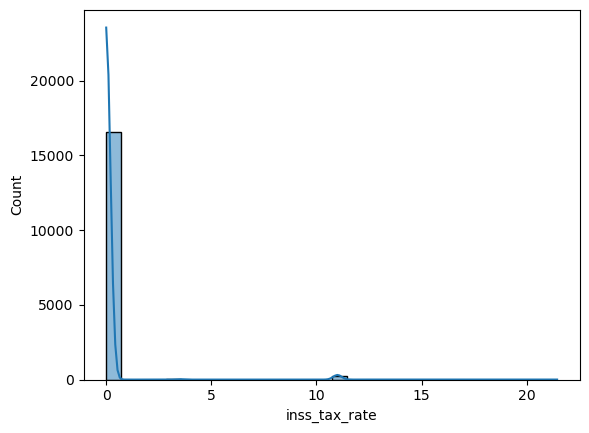

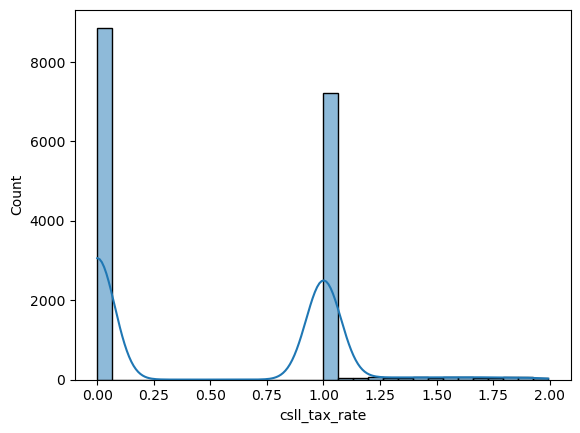

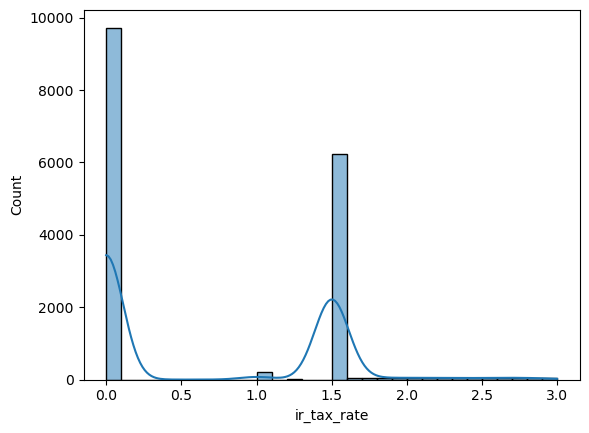

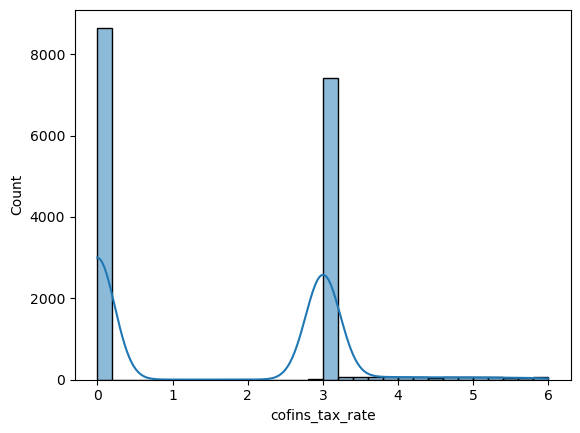

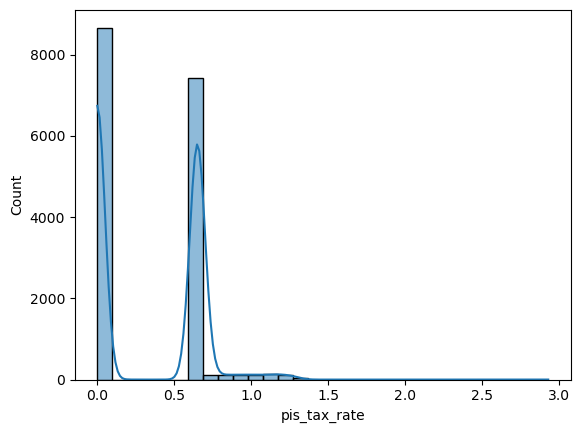

In [16]:
# Histograma de uma variável numérica
for col in num_cols[1:]:
    sns.histplot(df[col], bins=30, kde=True)
    plt.show()

## Visualização dos boxplots

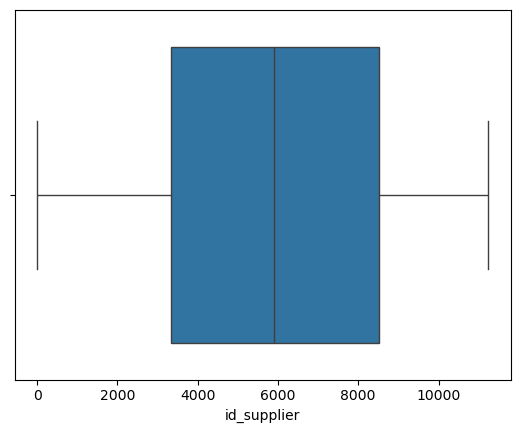

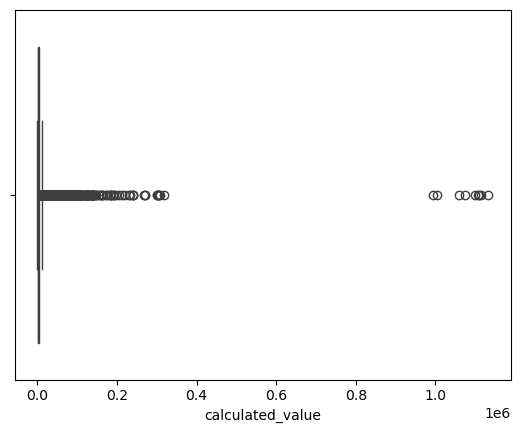

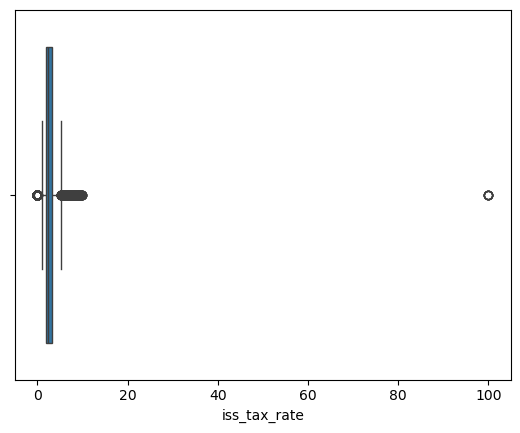

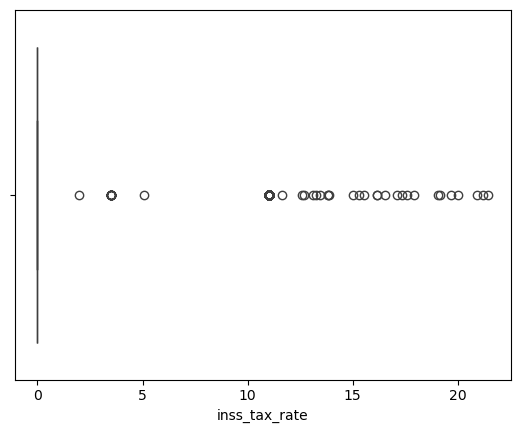

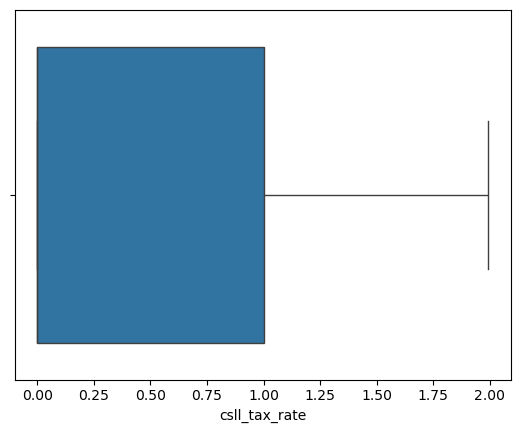

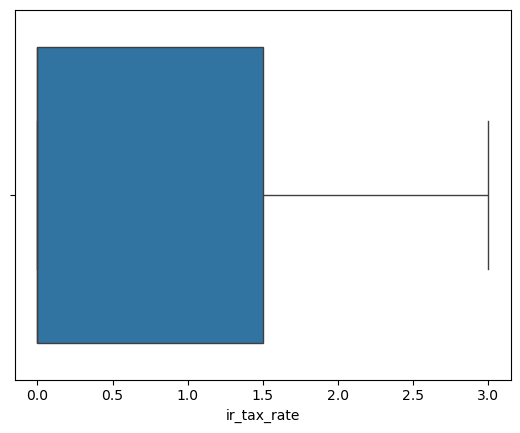

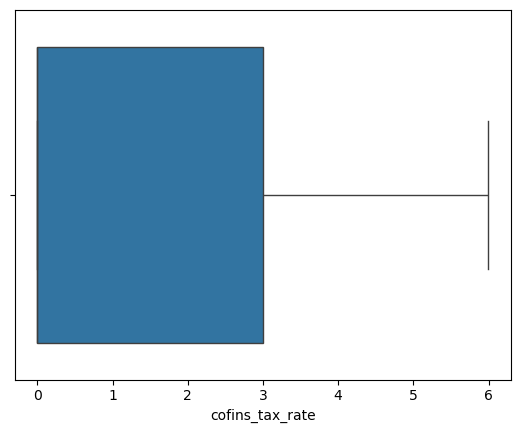

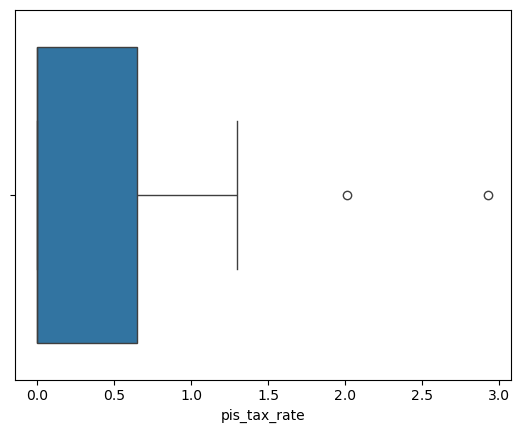

In [17]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

## Matriz de correlação

In [63]:
def imprimirMatrizDeCorr(df_temp): # dataframe temporário
    col_nums = df_temp.select_dtypes(include=["int64", "float64"]).columns
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_temp[col_nums].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

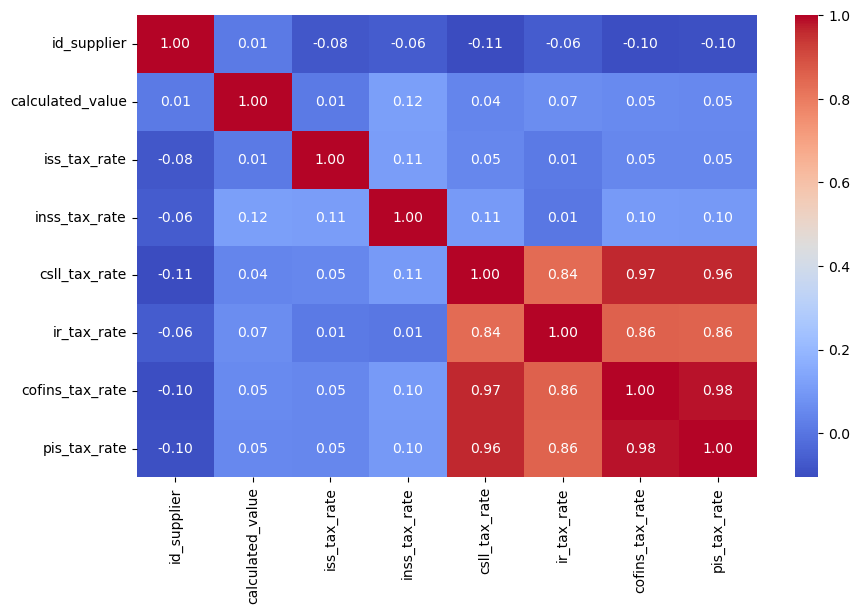

In [64]:
imprimirMatrizDeCorr(df)

- Features cofins_tax_rate, pis_tax_rate e csll_tax_rate estão muito correlacionadas (Multicolinearidade de variáveis).

### Possíveis soluções para multicolinearidade das variáveis

- Cálculo do VIF(Variance Inflation Factor)
  
 Mede a multicolinearidade entre variáveis de um conjunto de dados.

In [35]:
def VIF(df_temp, col_nums):  # O dataframe temporário e as colunas numéricas desse dataframe
    df_num = df_temp[col_nums].dropna()

    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_num.columns
    vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

    print(vif_data)

### Solução 1 - Remoção de duas das três features correlacionadas

In [24]:
df_sol1 = df.drop("cofins_tax_rate", axis = 1) 

In [25]:
df_sol1= df_sol1.drop(columns=["pis_tax_rate"], axis=1)

In [36]:
col_nums = df_sol1.select_dtypes(include=["int64", "float64"]).columns
VIF(df_sol1, col_nums)

            Feature       VIF
0       id_supplier  1.980720
1  calculated_value  1.061692
2      iss_tax_rate  1.922825
3     inss_tax_rate  1.079189
4     csll_tax_rate  6.290848
5       ir_tax_rate  5.867378


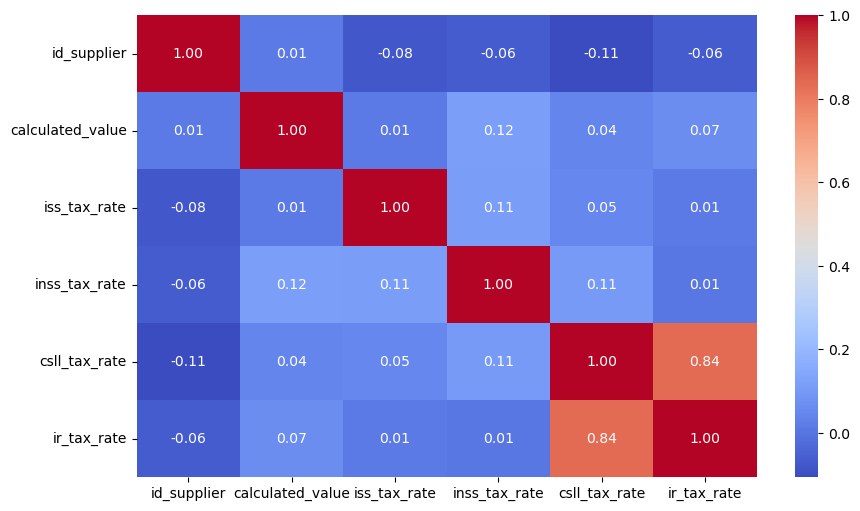

In [65]:
imprimirMatrizDeCorr(df_sol1)

### Solução 2 - Somatório das features correlacionadas

In [60]:
df_sol2 = df.copy()
df_sol2["total_tax_rate"] = df_sol2["cofins_tax_rate"] + df_sol2["pis_tax_rate"] + df_sol2["csll_tax_rate"]
df_sol2.drop(columns=["cofins_tax_rate", "pis_tax_rate", "csll_tax_rate"], inplace=True)

In [61]:
col_nums = df_sol2.select_dtypes(include=["int64", "float64"]).columns
VIF(df_sol2, col_nums)

            Feature       VIF
0       id_supplier  1.989667
1  calculated_value  1.060664
2      iss_tax_rate  1.925771
3     inss_tax_rate  1.081678
4       ir_tax_rate  6.697275
5    total_tax_rate  7.325354


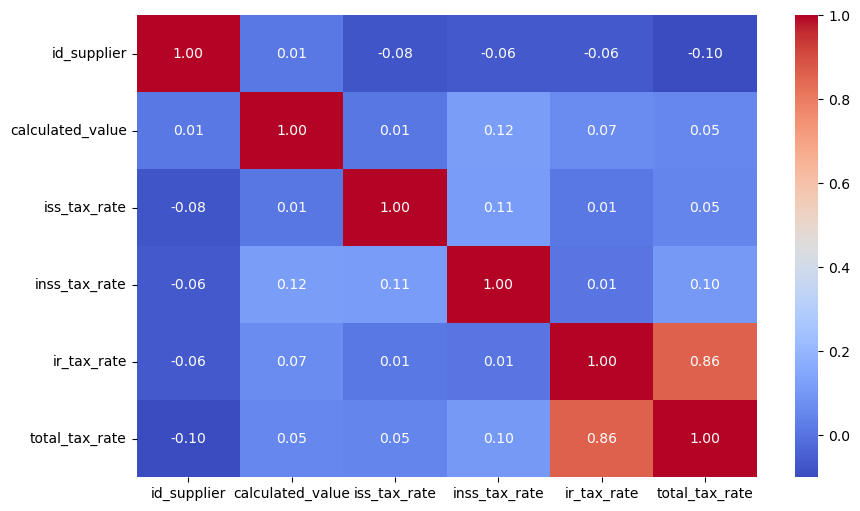

In [66]:
imprimirMatrizDeCorr(df_sol2)

### Solução 3 - Redução de Dimensionalidade com o PCA

In [62]:
df_sol3 = df.copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sol3[["csll_tax_rate", "cofins_tax_rate", "pis_tax_rate"]])

pca = PCA(n_components=1)
df_sol3["pca_tax_rate"] = pca.fit_transform(df_scaled)

df_sol3 = df_sol3.drop(columns=["csll_tax_rate", "cofins_tax_rate", "pis_tax_rate"])

In [43]:
col_nums = df_sol3.select_dtypes(include=["int64", "float64"]).columns
VIF(df_sol3, col_nums)

            Feature       VIF
0       id_supplier  2.704874
1  calculated_value  1.062325
2      iss_tax_rate  1.961690
3     inss_tax_rate  1.068149
4       ir_tax_rate  4.679170
5      pca_tax_rate  3.183071


- Verificação se houve perda de informações

In [47]:
pca.explained_variance_ratio_

array([0.98037141])

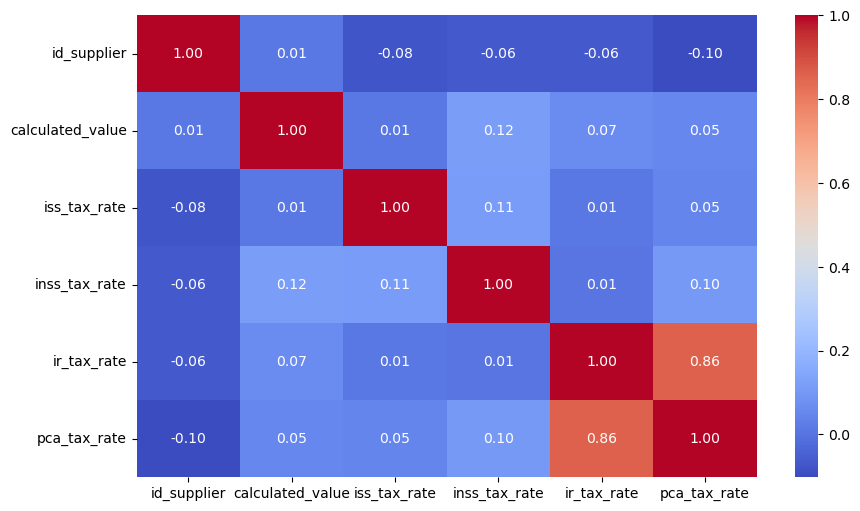

In [67]:
imprimirMatrizDeCorr(df_sol3)

In [71]:
df = df_sol3.copy()

## Relação de Variáveis numéricas e Class Label

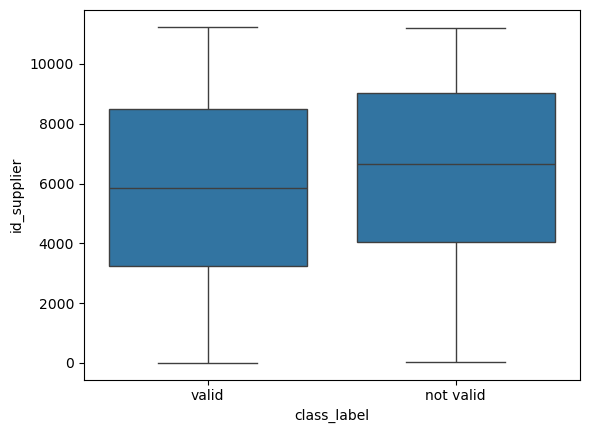

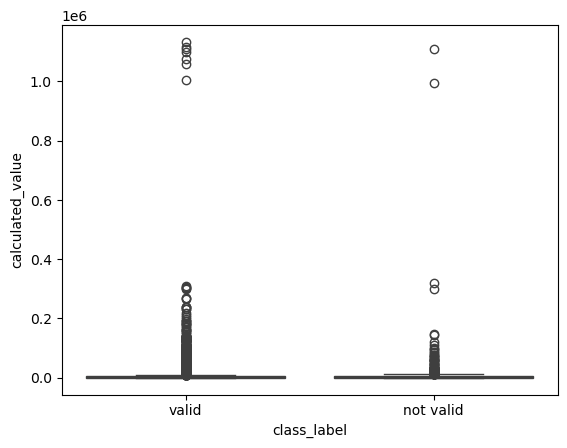

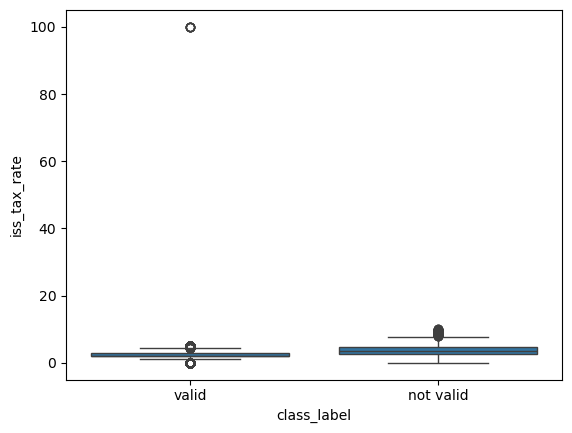

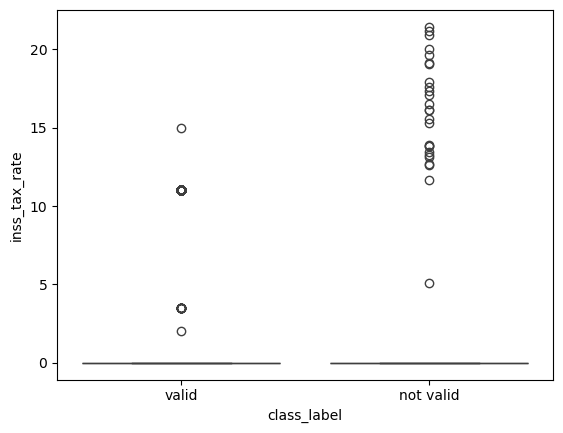

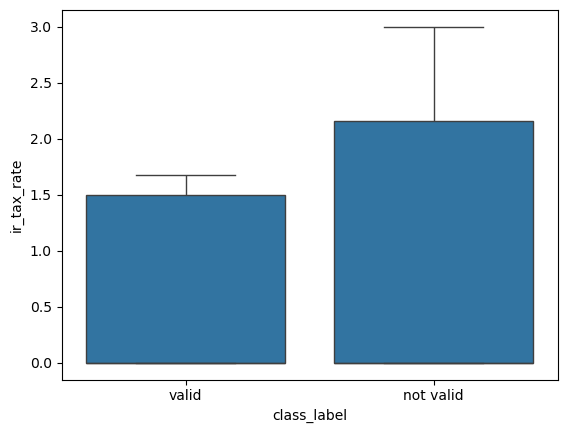

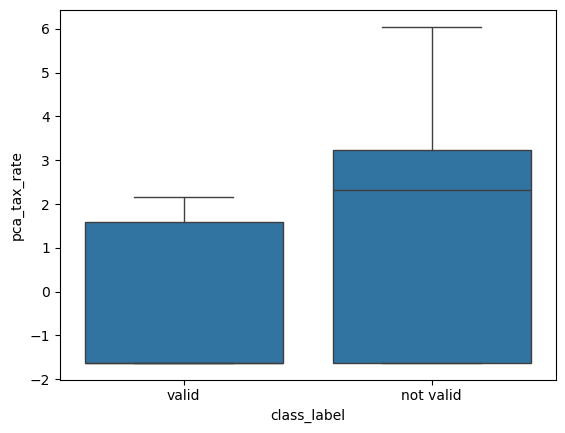

In [73]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    sns.boxplot(x=df["class_label"], y=df[col])
    plt.show()

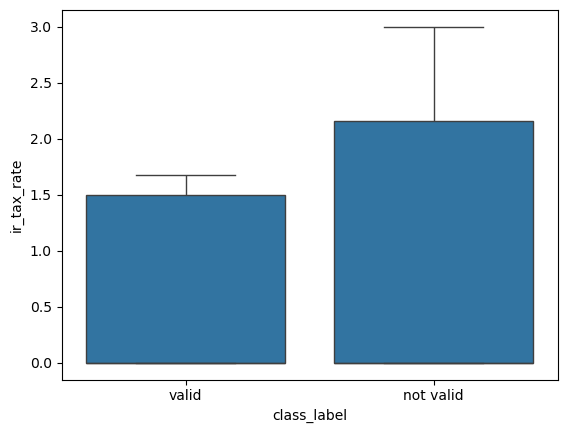

In [102]:
sns.boxplot(x=df["class_label"], y=df["ir_tax_rate"])
plt.show()

## Análise da feature Data

In [92]:
def analise_da_data(df_temp, coluna_data):
    df_temp[coluna_data] = pd.to_datetime(df_temp[coluna_data], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")

    df_temp["Ano"] = df_temp[coluna_data].dt.year
    df_temp["Mês"] = df_temp[coluna_data].dt.month
    df_temp["Dia"] = df_temp[coluna_data].dt.day
    df_temp["Hora"] = df_temp[coluna_data].dt.hour
    df_temp["Minuto"] = df_temp[coluna_data].dt.minute
    df_temp["Segundo"] = df_temp[coluna_data].dt.second
    df_temp["Milissegundo"] = df_temp[coluna_data].dt.microsecond // 1000  # Converte microssegundos para milissegundos

    return df_temp

df_transformado = analise_da_data(pd.DataFrame(df['issue_date']), "issue_date")
display(df_transformado)

,issue_date,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
0,2024-10-14 00:00:00,2024,10,14,0,0,0,0
1,2024-10-16 00:00:00,2024,10,16,0,0,0,0
2,2024-10-15 16:40:24,2024,10,15,16,40,24,0
3,2024-10-17 00:00:00,2024,10,17,0,0,0,0
4,2024-10-07 17:04:16,2024,10,7,17,4,16,0
...,...,...,...,...,...,...,...,...
16838,2025-01-01 08:25:39,2025,1,1,8,25,39,0
16839,2025-01-07 18:25:37,2025,1,7,18,25,37,0
16840,2025-01-03 12:18:11,2025,1,3,12,18,11,0
16841,2025-01-08 07:53:52,2025,1,8,7,53,52,0


- Análise de valores válidos de cada parte da data

In [91]:
df_transformado.describe()

,issue_date,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
count,16843,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.0
mean,2024-11-10 12:16:24.494864384,2024.024521,10.749985,9.167844,7.076708,16.322983,16.016565,0.0
min,2023-05-11 14:11:36,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,2024-10-16 00:00:00,2024.000000,10.000000,3.000000,0.000000,0.000000,0.000000,0.0
50%,2024-11-11 00:00:00,2024.000000,11.000000,8.000000,8.000000,6.000000,5.000000,0.0
75%,2024-12-03 14:02:33.500000,2024.000000,12.000000,14.000000,13.000000,33.000000,31.000000,0.0
max,2025-01-08 17:04:21,2025.000000,12.000000,31.000000,23.000000,59.000000,59.000000,0.0
std,NaN,0.155811,1.776394,6.679094,6.909886,19.472983,19.356465,0.0


- A partir da análise, os valores de data são válidos, porém não há necessidade dessa feature para o treinamento do modelo, visto que eles não influenciam o valor do rótulo.

# Pré-processamento de Dados

## Limpeza de Dados

- Remoção dos dados faltantes das features categóricas

In [97]:
df = df.dropna(subset=["id_supplier", "state"])

- Visualização dos dados faltantes restantes

Com a remoção das amostras ausentes, os valores ausentes da feature "iss_tax_rate" foram removidos também.

In [98]:
df.isnull().sum()

issue_date                     0
id_supplier                    0
iss_retention                  0
lc116                          0
calculated_value               0
iss_tax_rate                   0
inss_tax_rate                  0
ir_tax_rate                    0
opting_for_simples_nacional    0
state                          0
class_label                    0
pca_tax_rate                   0
Ano                            0
Mês                            0
Dia                            0
Hora                           0
Minuto                         0
Segundo                        0
Milissegundo                   0
dtype: int64

## Engenharia de Features

### Remoção da coluna de data

In [104]:
df.drop('issue_date', axis = 1, inplace=True)

### Inserção das features referentes a issue_date

In [108]:
df["Ano"] = df_transformado["Ano"]
df["Mês"] = df_transformado["Mês"]
df["Dia"] = df_transformado["Dia"]
df["Hora"] = df_transformado["Hora"]
df["Minuto"] = df_transformado["Minuto"]
df["Segundo"] = df_transformado["Segundo"]
df["Milissegundo"] = df_transformado["Milissegundo"]
df

,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
0,7101.0,True,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid,2024,10,14,0,0,0,0
1,5839.0,True,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,True,AM,not valid,2024,10,16,0,0,0,0
2,974.0,False,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,False,PA,valid,2024,10,15,16,40,24,0
3,9099.0,True,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,True,PA,valid,2024,10,17,0,0,0,0
4,3434.0,False,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid,2024,10,7,17,4,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,11010.0,False,1.07,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,False,AM,valid,2025,1,1,8,25,39,0
16839,6460.0,False,16.01,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,True,AM,valid,2025,1,7,18,25,37,0
16840,769.0,False,1.07,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid,2025,1,3,12,18,11,0
16841,4822.0,False,4.02,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,False,AC,valid,2025,1,8,7,53,52,0


### Codificação de Variáveis Categóricas

- Codificação de variáveis booleanas

In [110]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)
df

,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
0,7101.0,1,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,1,PA,valid,2024,10,14,0,0,0,0
1,5839.0,1,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,1,AM,not valid,2024,10,16,0,0,0,0
2,974.0,0,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,0,PA,valid,2024,10,15,16,40,24,0
3,9099.0,1,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,1,PA,valid,2024,10,17,0,0,0,0
4,3434.0,0,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,0,AM,valid,2024,10,7,17,4,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,1.07,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,0,AM,valid,2025,1,1,8,25,39,0
16839,6460.0,0,16.01,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,1,AM,valid,2025,1,7,18,25,37,0
16840,769.0,0,1.07,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,0,AM,valid,2025,1,3,12,18,11,0
16841,4822.0,0,4.02,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,0,AC,valid,2025,1,8,7,53,52,0


- Codificação da class_label como booleana

In [112]:
df["class_label"] = df["class_label"].map({"not valid": 0, "valid": 1})

In [113]:
df

,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
0,7101.0,1,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,1,PA,1,2024,10,14,0,0,0,0
1,5839.0,1,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,1,AM,0,2024,10,16,0,0,0,0
2,974.0,0,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,0,PA,1,2024,10,15,16,40,24,0
3,9099.0,1,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,1,PA,1,2024,10,17,0,0,0,0
4,3434.0,0,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,0,AM,1,2024,10,7,17,4,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,1.07,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,0,AM,1,2025,1,1,8,25,39,0
16839,6460.0,0,16.01,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,1,AM,1,2025,1,7,18,25,37,0
16840,769.0,0,1.07,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,0,AM,1,2025,1,3,12,18,11,0
16841,4822.0,0,4.02,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,0,AC,1,2025,1,8,7,53,52,0


- Codificação das demais variáveis categóricas

In [114]:
cat_cols = df.select_dtypes(include=["object"]).columns
df = pd.get_dummies(df, columns=cat_cols, dtype=int, drop_first=True)
df

,id_supplier,iss_retention,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,...,lc116_7.12,lc116_7.13,lc116_8.02,lc116_9.01,lc116_9.02,lc116_99.99,state_AM,state_PA,state_RO,state_RR
0,7101.0,1,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,0,1,0,0
1,5839.0,1,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,1,0,0,0
2,974.0,0,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,0
3,9099.0,1,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,0,1,0,0
4,3434.0,0,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,0,...,0,0,0,0,0,0,1,0,0,0
16839,6460.0,0,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,1,0,0,0
16840,769.0,0,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,0,...,0,0,0,0,0,0,1,0,0,0
16841,4822.0,0,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,0,...,0,0,0,0,0,0,0,0,0,0


- Verificação dos tipos de variáveis após a codificação de variáveis

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16843 entries, 0 to 16842
Columns: 139 entries, id_supplier to state_RR
dtypes: float64(8), int32(130), int64(1)
memory usage: 9.5 MB


## Divisão do Dataset

In [120]:
X = df.drop('class_label', axis=1)
y = df['class_label']

In [ ]:
- Divisão do dataset de 70% para treino, 20% de validação e 10% teste

In [122]:
# Passo 1: separar em Treino (70%) e TEMP (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

# Passo 2: do TEMP (30%), separar em Validação (20%) e Teste (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, shuffle=True)

# Modelo de Classificação